# Evaluation of the intrinsic dimension of rocket transformation

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from aeon.transformations.collection.convolution_based import MiniRocket
from sklearn.decomposition import PCA


from src import synthetic_data
from src import intrinsic_dim,logdet,effective_rank,fast_condition_number

In [67]:

# 1. Generate the custom dataset
print("Generating custom dataset...")
# X, y = synthetic_data.generate_custom_dataset(n_samples_per_class=100, n_timestamps=100) # Reduced samples for faster training
from aeon.datasets import load_classification
# 1. Load the BasicMotions dataset
# dataset_name = "PhonemeSpectra"
dataset_name="Meat"
dataset_name="Beef"
dataset_name="Ham"
# dataset_name = "ElectricDevices"
# dataset_name="TwoPatterns"
# X, y = load_classification("EthanolConcentration")
# X, y = load_classification("BasicMotions")
# X, y = load_classification("Beef")
# X, y = load_classification("Meat")
# X, y = load_classification("Ham")
#X,y=load_classification("FordB")
X_train,y_train=load_classification(dataset_name,split="train")
X_test,y_test=load_classification(dataset_name,split="test")


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# 2. Split the dataset into training and testing sets

# plt.imshow(pd.DataFrame(X_train.T.reshape(-1,30)).corr())
# plt.colorbar()
# plt.show()
print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing data shape: X_test={X_test.shape}, y_test={y_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

# 3. Initialize and train the MiniRocket classifier
print("Training MiniRocketClassifier...")


Generating custom dataset...
Training data shape: X_train=(109, 1, 431), y_train=(109,)
Testing data shape: X_test=(105, 1, 431), y_test=(105,)
Number of classes: 2
Training MiniRocketClassifier...


In [68]:
def train_model(n):
    from sklearn.linear_model import RidgeClassifierCV
    from sklearn.metrics import accuracy_score
    pipeline = make_pipeline(MiniRocket(n_kernels=n,random_state=42),StandardScaler(), RidgeClassifierCV(alphas=np.logspace(-7, 7, 10)))#RBFSampler(gamma=0.00000055,n_components=155),
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test) # Corrected from y_test to X_test

    # 5. Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [69]:
mydict={}

id=False
effective_rank=False
condition_number_slow=False
condition_number_fast=True
train=True
i=0
for n in np.logspace(2, 4,8).astype(int):#[84,170,3500]:#
# for n in [84,3500]:#
    number_dict={}
    i+=1
    print(f"{i}:n_kernels={n}")
    pipeline = make_pipeline(MiniRocket(n_kernels=n,random_state=42),StandardScaler())
    Xt=pipeline.fit_transform(X_train)
    if id:
        id=intrinsic_dim.intrinsic_dimension_2nn(Xt)
        number_dict.update({"id" :id})
    if effective_rank:
        eff_rank=effective_rank.effective_rank_truncated(Xt,n_components=n//2)[0]
        number_dict.update({"effective_rank":eff_rank})
    if condition_number_slow:
        pca=PCA(svd_solver="randomized").fit(Xt)
        eigv=pca.explained_variance_
        # q=np.quantile(eigv,[0.95,0.05])
        sorted_eigv=np.sort(eigv)
        lowest_nonzero=np.min(sorted_eigv[sorted_eigv>1e-7])
        n_null=np.sum(sorted_eigv<1e-7)
        plt.hist(np.log10(eigv),bins=30,label=f"n_kernels={n}",density=True,alpha=0.5)
        i_noise=-int(eff_rank)
        max_eigv=sorted_eigv[i]
        max_eigv=np.max(max_eigv)
        cond=max_eigv/lowest_nonzero
        number_dict.update({"condition_number":cond})
    if condition_number_fast:
        fast_cond=fast_condition_number.effective_condition_number(Xt)
        number_dict.update({"fast_condition_number":fast_cond})
        print(f"fast condition number: {fast_cond}")
    if train:
        accuracy=train_model(n)
        number_dict.update({"accuracy":accuracy})
        print(f"accuracy: {accuracy}")
    mydict.update({n:number_dict})#"id/n":id/np.log10(n),"logdet/n":logdet.logdet_cholesky(Xt)/n
    # plt.xlim(-14,3)
    # plt.show()
    
# plt.legend()
df=pd.DataFrame(mydict).T

1:n_kernels=100
fast condition number: 283.7743999770528
accuracy: 0.6190476190476191
2:n_kernels=193
fast condition number: 112.37837673044454
accuracy: 0.6666666666666666
3:n_kernels=372
fast condition number: 37.78829068679688
accuracy: 0.6952380952380952
4:n_kernels=719
fast condition number: 30.34952032675509
accuracy: 0.7238095238095238
5:n_kernels=1389
fast condition number: 25.933054487644707
accuracy: 0.6952380952380952
6:n_kernels=2682
fast condition number: 24.21352652116972
accuracy: 0.7333333333333333
7:n_kernels=5179
fast condition number: 23.44534647835611
accuracy: 0.7619047619047619
8:n_kernels=10000
fast condition number: 23.854275981954796
accuracy: 0.7238095238095238


In [70]:
df

,fast_condition_number,accuracy
100,283.774400,0.619048
193,112.378377,0.666667
372,37.788291,0.695238
719,30.349520,0.723810
1389,25.933054,0.695238
2682,24.213527,0.733333
5179,23.445346,0.761905
10000,23.854276,0.723810


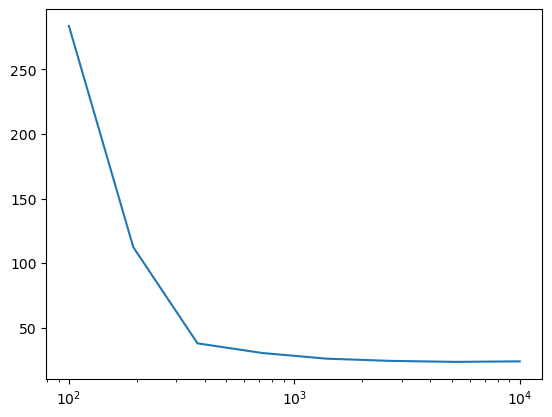

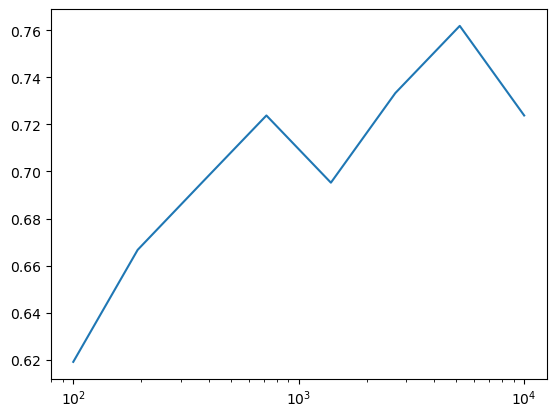

In [71]:
df["fast_condition_number"].plot(label="fast_condition_number")
plt.xscale("log")
plt.show()
# df["id"].plot(label="Intrinsic Dimension")
# plt.show()
df["accuracy"].plot(label="Accuracy")
plt.xscale("log")

In [72]:
# df["id"].plot(label="Intrinsic Dimension")
# plt.xscale("log")#df["id/n"].plot(label="Intrinsic Dimension/log(n_kernels)")
# plt.xscale("log")
# df["logdet/n"].plot(label="logdet/n")
# plt.xscale("log")
# df["effective_rank"].plot(label="effective_rank")
# plt.xscale("log")
# plt.show()
# df["condition_number"].plot(label="condition_number")
# plt.xscale("log")
# plt.yscale("log")

Training MiniRocketClassifier...
Training complete.
Model Accuracy: 0.7524

MiniRocket training on BasicMotions dataset completed successfully.


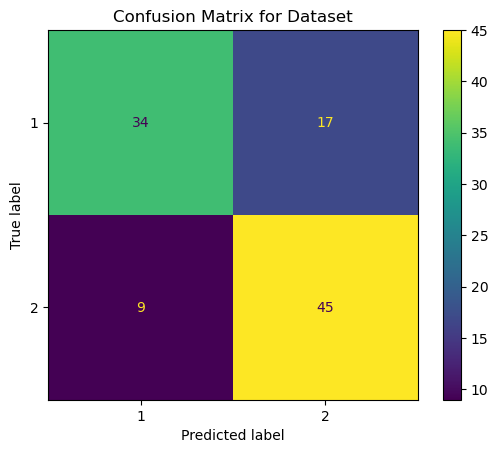

In [73]:
from sklearn.metrics import accuracy_score
from sklearn.kernel_approximation import RBFSampler

# MiniRocket is a transformation, so we'll use it within a pipeline with a classifier.
# For simplicity, we'll use a RidgeClassifierCV as recommended with ROCKET.
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import HistGradientBoostingClassifier

print("Training MiniRocketClassifier...")
pipeline = make_pipeline(MiniRocket(n_kernels=2000,random_state=42),StandardScaler(), RidgeClassifierCV(alphas=np.logspace(-7, 7, 10)))#RBFSampler(gamma=0.00000055,n_components=155),
pipeline.fit(X_train, y_train)
print("Training complete.")

# 4. Make predictions on the test set
y_pred = pipeline.predict(X_test) # Corrected from y_test to X_test

# 5. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

print("\nMiniRocket training on BasicMotions dataset completed successfully.")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 6. Generate and display Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()
plt.title("Confusion Matrix for Dataset")
plt.show()